# 1. Import Libraries

Import all the necessary libraries which will be used in this project.



In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
import re
!pip install gensim
import gensim
import gensim.corpora as corpora
!pip install pyLDAvis
import pyLDAvis
from pyLDAvis import sklearn as sklearn_lda
import pickle 


# 2. Load data file

Load the data file containing research papers into a dataframe called 'dataset'.

In [0]:
#Load data file
dataset = pd.read_csv(r'research_papers.csv', encoding='ISO-8859–1')

# 3. Clean Data

I dropped the unnecessary columns like 'ID', 'Author','Year', 'Conference/Journal', and focused solely on the 'Abstract' and 'Conclusion' columns of each paper entry. For papers with no conclusions, I filled the empty cell with the text "No conclusion". Next, I merged the two columns 'Abstract' and 'Conclusion' to form a new column called 'PaperText'. 

In [28]:
#Remove the unecessary columns
dataset = dataset.drop(columns=['Id', 'Reference', 'Authors', 'Year', 'Conference/ Journal'], axis=1)

#Fill in the empty cells
dataset = dataset.fillna('No conclusion')

#Merge abstract and conclusion
dataset['Paper_Text'] = dataset["Abstract"] + dataset["Conclusion"]

#show first 5 records
dataset.head()

,Title,Codes,Abstract,Conclusion,Paper_Text
0,Design Considerations to Increase Block-based ...,"BBL, DES, SR, KN, CE, CN, DT, CC",Block-based programming languages are a popula...,The initial version of accessible Blockly shou...,Block-based programming languages are a popula...
1,Exploration of the use of auditory cues in cod...,"AP, CN, CC, BBL, DES, DT, ACUE, SM",Visual programming languages are commonplace i...,No conclusion,Visual programming languages are commonplace i...
2,Towards making block-based programming accessi...,"BBL, DES, DT, WAPP, PC",Block-based programming environments are not a...,No conclusion,Block-based programming environments are not a...
3,Blocks4All: overcoming accessibility barriers ...,"BBL, CH, CN, CC, SR, TS, SM, KDG, MSH",Blocks-based programming environments are a po...,We conducted an evaluation of current blocks-b...,Blocks-based programming environments are a po...
4,Making the Blockly Library Accessible via Touc...,"BBL, TS, SR, DES, CN, CE",Block-based programming environments are a pop...,We present two interfaces which were designed ...,Block-based programming environments are a pop...


# 4. Preprocess Data

Tokenize each sentence into a list of words, remove punctuations, remove stopwords and words of length less than 3, and then lemmatize.

In [0]:
#function for lemmatization
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

# tokenization
tokenized_data = dataset['Paper_Text'].apply(lambda x: x.split()) 

# Remove punctuation
tokenized_data = tokenized_data.apply(lambda x: [re.sub('[-,()\\!?]', '', item) for item in x])
tokenized_data = tokenized_data.apply(lambda x: [re.sub('[.]', ' ', item) for item in x])

#turn to lowercase
tokenized_data = tokenized_data.apply(lambda x: [item.lower() for item in x])

# remove stop-words and words of length less than 3
stop_words = stopwords.words('english')
stop_words.extend(['from','use', 'using','uses','user', 'users', 'well', 'study', 'survey', 'think'])
tokenized_data = tokenized_data.apply(lambda x: [item for item in x if item not in stop_words and len(item)>3])

#lemmatize by calling lemmatization function
tokenized_data= tokenized_data.apply(lambda x: [get_lemma(item) for item in x])


# 5. Create Bigram and Trigram
Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

Some examples in our corpus are: ‘visually_impaired’, ‘programming_language’, ‘block_based_programming’, 'programming environment' etc.

Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. The higher the values of these param, the harder it is for words to be combined to bigrams

In [0]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tokenized_data, min_count=5, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tokenized_data], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[tokenized_data[0]]])

In [0]:
# Define functions for creating bigrams and trigrams.
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]


In [0]:
# Form Bigrams
tokenized_data_bigrams = make_bigrams(tokenized_data)

 # Form Trigrams
tokenized_data_trigrams = make_trigrams(tokenized_data)

In [0]:
# de-tokenization, combine tokens together
detokenized_data = []
for i in range(len(dataset)):
    t = ' '.join(tokenized_data_trigrams[i])
    detokenized_data.append(t)
    
dataset['clean_text']= detokenized_data 
documents = dataset['clean_text']



# 6. Perform Exploratory Analysis
To verify whether the preprocessing happened correctly, we’ll make a word cloud using the wordcloud package to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.

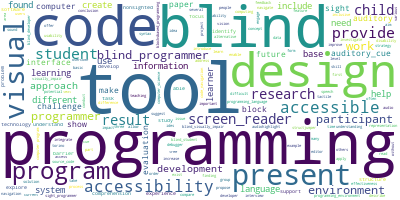

In [35]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(documents.values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

# 7. Create Document-Term Matrix
This is the first step towards topic modeling. We need to represent each and every term and document as a vector.We will use sklearn's TfidfVectorizer to create a document-term matrix using only 1000 terms (words) from our corpus.

In [0]:
#Set variable number of terms 
no_terms = 1000

# NMF uses the tf-idf count vectorizer
# Initialise the count vectorizer with the English stop words
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, max_features=no_terms, stop_words='english')
# Fit and transform the text
document_matrix = vectorizer.fit_transform(documents)

#get features
feature_names = vectorizer.get_feature_names()


# 8. Apply Topic Model
We will use the document-term matrix and decompose it into multiple matrices. We will use sklearn's NMF to perform the task of matrix decomposition. The number of topics can be specified by using the n_components parameter.

In [37]:
#Set variables umber of topics and top words.
no_topics = 10
no_top_words = 10

# Function for displaying topics
def display_topic(model, feature_names, num_topics, no_top_words, model_name):    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    print("Model %s:" % model_name)
    word_dict = {};
    for i in range(num_topics):
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-no_top_words - 1:-1]
        words = [feature_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i)] = words;
    dict = pd.DataFrame(word_dict);
    dict.to_csv('%s.csv' % model_name)
    return dict

# Apply NMF topic model to document-term matrix
nmf_model = NMF(n_components=no_topics, random_state=42, alpha=.1, l1_ratio=.5, init='nndsvd').fit(document_matrix)
#display topics for nmf model
display_topic(nmf_model, feature_names, no_topics, no_top_words, 'NMF_Model_Result')


Model NMF_Model_Result:


,Topic # 00,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09
0,program,child,blind_learner,blind_student,blockbased_programming,blind_developer,structjumper,story,sight_programmer,solution
1,auditory,learning,audio_programming_language,barrier,blockly,challenge,skimming,block,blind_programmer,blind
2,auditory_cue,torino,apl,computer_science,computing,developer,participant,accessible,blind,development
3,nonsighted,design,skill,project,environment,face,structure,blockbased_programming_language,area,aid
4,computer,computational,novice_blind_learner,structjumper,library,software_developer,blind_programmer,tangible,reading,description_language
5,research,inclusive,solve_problem,interview,impaired,software,complete,student,prioritize,graphic_interface
6,sound,physical,interact,information,design,difficulty,class,game,method,regard
7,blind,vision,motivating,create,visually,ides,eclipse,output,difference,usage
8,cue,teacher,help,goal,outreach,blind,navigate,audio,suggest,graphical_interface
9,comprehension,nonspecialist,write_program,dissertation,foster,need,nest,novice_programmer,screen_reader,problem


# 9. Analyzing our NMF model
Now that we have a trained model let’s visualize the topics for interpretability. To do so, we’ll use a popular visualization package, pyLDAvis which is designed to help interactively with:

Better understanding and interpreting individual topics, and
Better understanding the relationships between the topics.
For (1), you can manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter. This can help when you’re trying to assign a human interpretable name or “meaning” to each topic. For (2), exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

In [38]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = sklearn_lda.prepare(nmf_model, nmf_matrix, nmf_vectorizer)
LDAvis_prepared

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.046432 -0.060745       1        1  28.984868
1     -0.280743  0.107633       2        1  13.272847
7     -0.245475  0.038103       3        1  11.915174
5      0.160219  0.075452       4        1   9.645879
6      0.220662  0.129751       5        1   7.580157
3      0.031313  0.286639       6        1   6.457751
2     -0.100707 -0.039736       7        1   6.253687
4     -0.151655 -0.261759       8        1   6.173575
8      0.199473 -0.225725       9        1   5.141566
9      0.120481 -0.049613      10        1   4.574497, topic_info=                 Term      Freq     Total Category  logprob  loglift
106             child  3.000000  3.000000  Default  30.0000  30.0000
660      structjumper  3.000000  3.000000  Default  29.0000  29.0000
79      blind_student  2.000000  2.000000  Default  28.0000  28.0000
75              blind  4.000000  4.000000  Default  27.0000  27.0000
78   blind_programmer  2.000000  2.000000  Default  26.0000  26.0000
..                ...       ...       ...      ...      ...      ...
38           approach  0.289095  1.724984  Topic10  -4.0044   1.2985
427              make  0.169504  0.959269  Topic10  -4.5382   1.3514
584          research  0.179026  2.286990  Topic10  -4.4836   0.5372
191         different  0.164384  1.086168  Topic10  -4.5689   1.1965
230            enable  0.160276  1.217715  Topic10  -4.5942   1.0568

[563 rows x 6 columns], token_table=      Topic      Freq                         Term
term                                              
3         3  1.080517                    abilities
4         2  1.083351                      ability
8         8  0.819794                       access
9         1  0.544254                accessibility
10        3  0.757868                   accessible
...     ...       ...                          ...
745       2  0.955128                       vision
747       1  1.197471  visual_programming_language
749       8  1.563385                     visually
758       1  0.703409                         work
769       2  1.932203                        young

[175 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 8, 6, 7, 4, 3, 5, 9, 10])

# 10. Classify papers under topics

Using the 10 topics generated by our NMF model, we categorize each paper in our corpus under one of the 10 topics.

In [0]:
#Use NMF model to assign topic to papers in corpus
nmf_topic_values = nmf_model.transform(nmf_matrix)
dataset['NMF Topic'] = nmf_topic_values.argmax(axis=1)

#Save dataframe to csv file
dataset.to_csv('final_results.csv')